# Project 7 

### Objective: To analyze airport data to understand the cause of airport delays using Principal Component Analysis and other modeling techniques.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import *
import sys
import pylab as pl
import numpy as np
import sklearn
import psycopg2 as psy
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import cluster, metrics
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

## Data Exploration

In [5]:
#loading data from csvs into three data frames
airports = pd.read_csv('airports.csv')
cancellations = pd.read_csv('airport_cancellations.csv')
operations = pd.read_csv('Airport_operations.csv')

In [6]:
print airports.shape
airports.head()

(5167, 13)


,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


In [7]:
print cancellations.shape
cancellations.head()

(805, 6)


,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [8]:
print operations.shape
operations.head()

(841, 15)


,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


### PostgreSQL database 

In [9]:
from sqlalchemy import create_engine

engine = create_engine("postgresql://@localhost:5432/airport")

In [10]:
%load_ext sql

//anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
//anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [11]:
%%sql 
postgresql://@localhost:5432/airport

u'Connected: @airport'

Load our csv files into tables

In [12]:
# airports.to_sql('airports', engine)
# operations.to_sql('operations', engine)
# cancellations.to_sql('cancellations',  engine)

In [13]:
%%sql 

SELECT * 
FROM airports 
LIMIT 5;

5 rows affected.


index,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,None,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.01933,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


In [14]:
%%sql 

SELECT *
FROM cancellations
LIMIT 5;

5 rows affected.


index,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [15]:
%%sql

SELECT *
FROM operations
LIMIT 5;

5 rows affected.


index,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.6,9.79,2.29,11.2,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.4,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


Join airport_cancellations.csv and airports.csv into one table

In [16]:
%%sql

SELECT *
FROM airports, cancellations
WHERE cancellations."Airport" = airports."LocID"
LIMIT 5; 

5 rows affected.


index,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available,index_1,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,727,SJU,2014.0,280.0,241.0,72.0,31.0
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,726,SJU,2013.0,127.0,94.0,65.0,64.0
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,725,SJU,2012.0,174.0,141.0,62.0,41.0
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,724,SJU,2011.0,240.0,201.0,101.0,55.0
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,723,SJU,2010.0,258.0,207.0,82.0,45.0


In [17]:
%%sql
CREATE TABLE airport_data 
AS(
SELECT *
FROM airports, cancellations
WHERE cancellations."Airport" = airports."LocID"); 

(psycopg2.ProgrammingError) column "index" specified more than once
 [SQL: 'CREATE TABLE airport_data \nAS(\nSELECT *\nFROM airports, cancellations\nWHERE cancellations."Airport" = airports."LocID");']


Query the database for our intial data

In [18]:
#df = pd.read_sql()

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [19]:
#merging data from all tables into one data frame
df = pd.merge(operations, cancellations, left_on=['airport', 'year'], right_on=['Airport','Year'], how='outer')

In [20]:
#shape of data frame 
df.shape

(847, 21)

In [21]:
#nulls
sum(df.Airport.isnull())

42

In [22]:
#removing any row with missing airport
df = df[df['airport'].isnull() != True]
df = df[df['Airport'].isnull() !=True]

In [23]:
df = pd.merge(df, airports, left_on='airport', right_on='LocID', how='left')
df.shape

(799, 34)

In [24]:
df.columns

Index([u'airport', u'year', u'departures for metric computation',
       u'arrivals for metric computation', u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay', u'Airport',
       u'Year', u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions', u'Arrival Diversions', u'Key', u'LocID',
       u'AP_NAME', u'ALIAS', u'Facility Type', u'FAA REGION', u'COUNTY',
       u'CITY', u'STATE', u'AP Type', u'Latitude', u'Longitude',
       u'Boundary Data Available'],
      dtype='object')

In [25]:
#removing unnecessary and duplicate columns 
del df['Airport']
del df['Year']
del df['Key']
del df['LocID']
del df['AP_NAME']
del df['ALIAS']
del df['Facility Type']
del df['Boundary Data Available']

In [26]:
#renaming columns
df.columns = [u'airport', u'year', u'numdepart',
       u'numarriv', u'pctontimegatedepart',
       u'pctontimearptdepart', u'pctontimegatearriv',
       u'avggatedepartdelay', u'avgtaxiouttime',
       u'avgtaxioutdelay', u'avgarptdepartdelay',
       u'avgairbdelay', u'avgtaxiindelay',
       u'avgblockdelay', u'avggatearrivdelay',
       u'departcancellations', u'arrivcancellations',
       u'departdiversions', u'arrivdiversions', u'FAAregion',
       u'county', u'city', u'state', u'APtype', u'latitude', u'longitude']

In [27]:
#df2 copied for pivot table analysis
df2=df
df.head()

,airport,year,numdepart,numarriv,pctontimegatedepart,pctontimearptdepart,pctontimegatearriv,avggatedepartdelay,avgtaxiouttime,avgtaxioutdelay,...,arrivcancellations,departdiversions,arrivdiversions,FAAregion,county,city,state,APtype,latitude,longitude
0,ABQ,2004.0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,...,235.0,71.0,46.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194
1,ABQ,2005.0,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,...,190.0,61.0,33.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194
2,ABQ,2006.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,...,329.0,71.0,124.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194
3,ABQ,2007.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,...,304.0,107.0,45.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194
4,ABQ,2008.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,...,300.0,79.0,42.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194


In [28]:
#pulling out important columns for data comparison
df1=df[[ u'year', u'numdepart',
       u'pctontimearptdepart', u'pctontimegatearriv',u'avgtaxiouttime', u'avgarptdepartdelay',
       u'departcancellations', u'arrivcancellations',
       u'departdiversions', u'arrivdiversions']]

In [29]:
for i in df.FAAregion.unique():
    print i, df[df.FAAregion==i].airport.unique()

ASW ['ABQ' 'AUS' 'DAL' 'DFW' 'HOU' 'IAH' 'MSY' 'SAT']
AAL ['ANC']
ASO ['ATL' 'BHM' 'BNA' 'CLT' 'CVG' 'FLL' 'JAX' 'MCO' 'MEM' 'MIA' 'PBI' 'RDU'
 'RSW' 'SDF' 'SJU' 'TPA']
ANE ['BDL' 'BOS' 'MHT' 'PVD']
AEA ['BUF' 'BWI' 'DCA' 'EWR' 'HPN' 'IAD' 'ISP' 'JFK' 'LGA' 'PHL' 'PIT' 'SWF']
AWP ['BUR' 'HNL' 'LAS' 'LAX' 'LGB' 'OAK' 'OGG' 'ONT' 'OXR' 'PHX' 'PSP' 'SAN'
 'SFO' 'SJC' 'SMF' 'SNA' 'TUS']
AGL ['CLE' 'DAY' 'DTW' 'IND' 'MDW' 'MKE' 'MSP' 'ORD' 'RFD']
ANM ['DEN' 'PDX' 'SEA' 'SLC']
ACE ['MCI' 'OMA' 'STL']


### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [30]:
#dummy variables for FAA region
df['key'] = range(len(df['FAAregion']))
df = pd.concat([df.drop('key',axis=1),pd.get_dummies(df['FAAregion'])], axis = 1)
df['key'] = range(len(df['APtype']))
df = pd.concat([df.drop('key',axis=1),pd.get_dummies(df['APtype'])], axis = 1)

#### 3.2 Format and Clean the Data

In [31]:
del df['FAAregion']
del df['county']
del df['city']
del df['state']
del df['APtype']
del df['latitude']
del df['longitude']

In [32]:
df.head()

,airport,year,numdepart,numarriv,pctontimegatedepart,pctontimearptdepart,pctontimegatearriv,avggatedepartdelay,avgtaxiouttime,avgtaxioutdelay,...,ACE,AEA,AGL,ANE,ANM,ASO,ASW,AWP,Federalized/Commercial,Public Use
0,ABQ,2004.0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,ABQ,2005.0,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,ABQ,2006.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,ABQ,2007.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,ABQ,2008.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Part 4: Define the Data

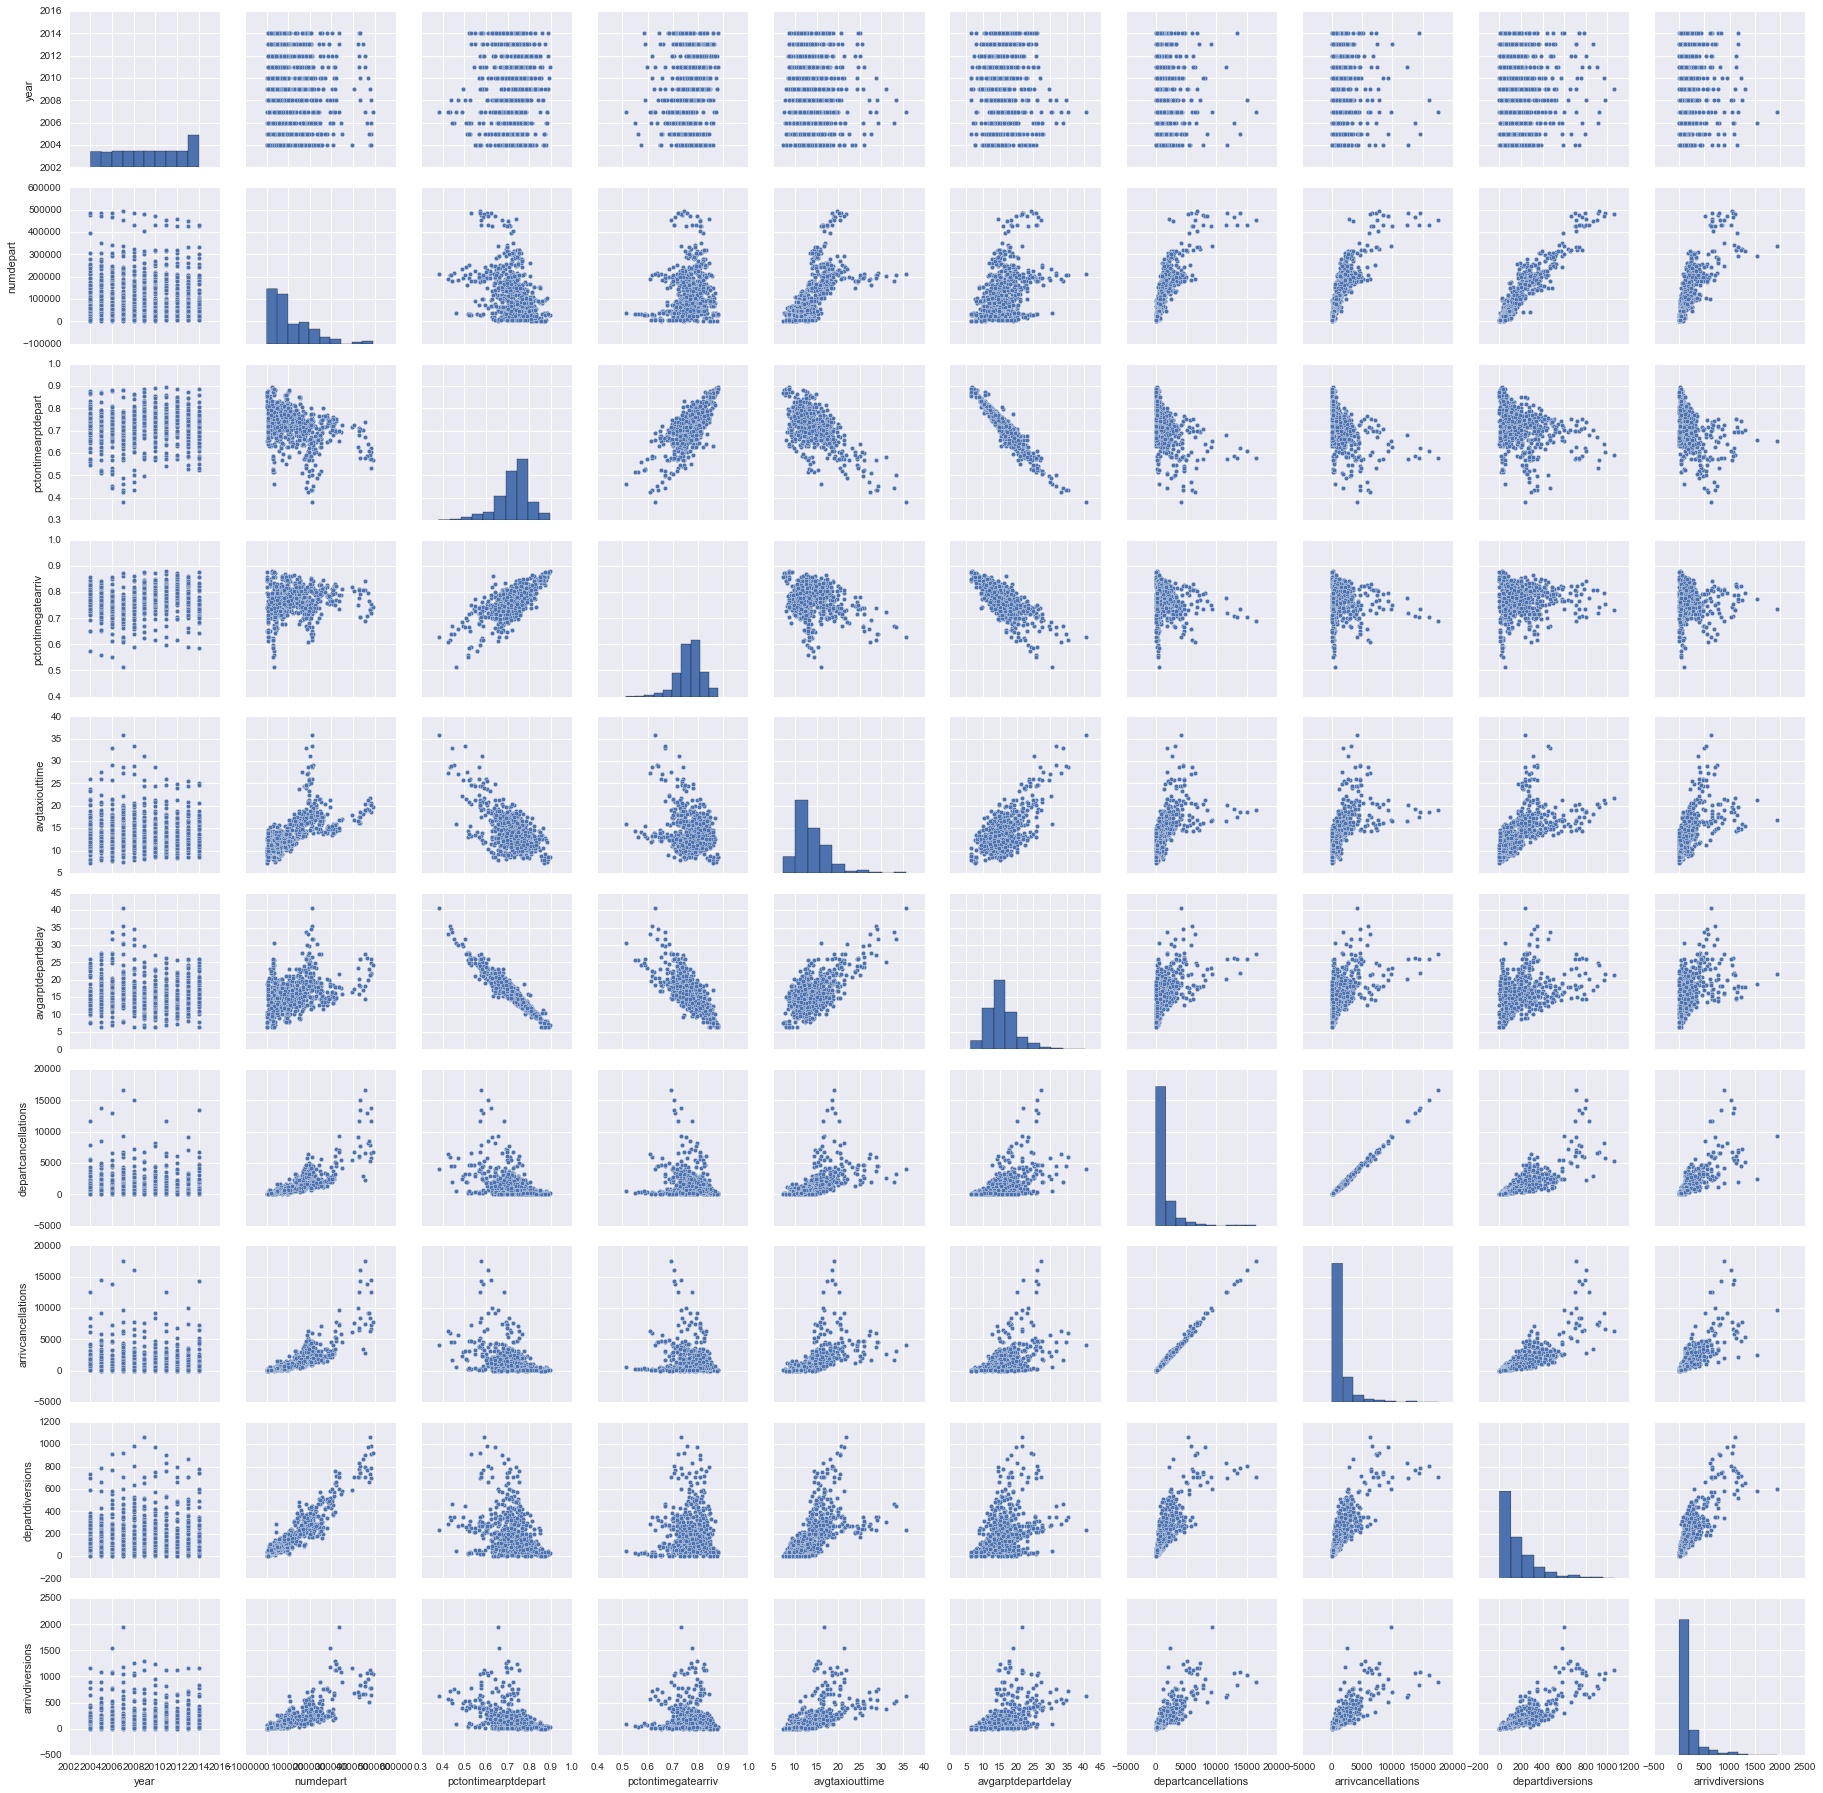

In [33]:
sns.pairplot(df1)

In [34]:
df2.head()

,airport,year,numdepart,numarriv,pctontimegatedepart,pctontimearptdepart,pctontimegatearriv,avggatedepartdelay,avgtaxiouttime,avgtaxioutdelay,...,departdiversions,arrivdiversions,FAAregion,county,city,state,APtype,latitude,longitude,key
0,ABQ,2004.0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,...,71.0,46.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,0
1,ABQ,2005.0,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,...,61.0,33.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,1
2,ABQ,2006.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,...,71.0,124.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,2
3,ABQ,2007.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,...,107.0,45.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,3
4,ABQ,2008.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,...,79.0,42.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,4


In [35]:
airportpivot = pd.pivot_table(df2, index=['year'],columns=['FAAregion'],values = ['pctontimegatearriv'],aggfunc=np.mean)
airportpivot

pctontimegatearriv                                          \
FAAregion                AAL       ACE       AEA       AGL       ANE   
year                                                                   
2004.0                0.6502  0.784533  0.738025  0.770313  0.763550   
2005.0                0.6955  0.773967  0.717667  0.767112  0.743675   
2006.0                0.7110  0.756967  0.702458  0.753811  0.728575   
2007.0                0.7196  0.728200  0.674117  0.725967  0.701450   
2008.0                0.7573  0.739667  0.713825  0.760689  0.742350   
2009.0                0.8264  0.788633  0.740750  0.811025  0.775375   
2010.0                0.8045  0.782833  0.746000  0.793600  0.762325   
2011.0                0.8292  0.778000  0.728200  0.790900  0.759450   
2012.0                0.8521  0.800833  0.755225  0.809044  0.777200   
2013.0                0.8631  0.756667  0.726283  0.770033  0.742750   
2014.0                0.8600  0.735833  0.723442  0.749350  0.741400   

                                                   
FAAregion       ANM       ASO       ASW       AWP  
year                                               
2004.0     0.814000  0.762581  0.775050  0.789000  
2005.0     0.799475  0.745844  0.779037  0.783600  
2006.0     0.784650  0.747125  0.761912  0.771773  
2007.0     0.765175  0.728800  0.738562  0.774112  
2008.0     0.792200  0.746387  0.761987  0.784635  
2009.0     0.828575  0.775263  0.794837  0.818765  
2010.0     0.832250  0.778419  0.785587  0.804524  
2011.0     0.833700  0.778444  0.790262  0.802119  
2012.0     0.845750  0.796531  0.796900  0.813237  
2013.0     0.815125  0.764288  0.756963  0.794375  
2014.0     0.808325  0.753731  0.736587  0.772163

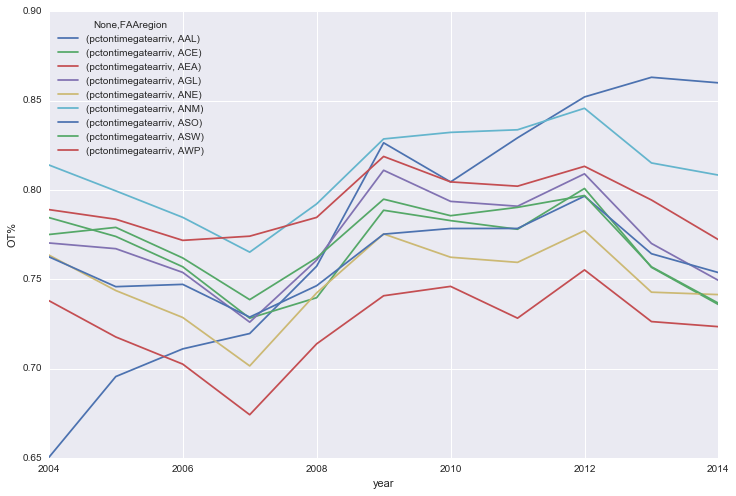

In [36]:
airportpivot.plot(kind='line',figsize=(12,8))
plt.ylabel('OT%')

The above graph shows the mean on-time gate arrival percent for each FAA region from 2004-2014. Most FAA regions remain pretty constant with ANM consistently the highest on-time percent. AEA remained at the lowest on-time percent for this period. AAL is the only region to show an improvement -- and a dramatic one at that. In 2004, this region's OT% was 0.65 (with the next lowest at 0.73), and in 2014 increased their OT% to the highest of all regions to 0.86 (with the second best at 0.81).

In [43]:
airportpivot2 = pd.pivot_table(df2, index=['FAAregion'],values = ['numdepart'],aggfunc=[np.sum])
airportpivot2.to_csv('airportpivot2.csv')
airportpivot2

,sum
,numdepart
FAAregion,
AAL,743903.0
ACE,2361983.0
AEA,15391042.0
AGL,13958380.0
ANE,3026082.0
ANM,7877998.0
ASO,21040049.0
ASW,10136633.0


In [42]:
airportpivot3 = pd.pivot_table(df2, index=['airport'],values = ['pctontimegatearriv','numdepart'],aggfunc=[np.mean])
airportpivot3.to_csv('airportpivot3.csv')
airportpivot3

mean                   
             numdepart pctontimegatearriv
airport                                  
ABQ       44830.454545           0.786673
ANC       67627.545455           0.778991
ATL      469004.000000           0.771736
AUS       53456.000000           0.751900
BDL       45903.090909           0.761436
BHM       28168.181818           0.727382
BNA       74937.454545           0.764827
BOS      174015.272727           0.749991
BUF       38447.000000           0.733809
BUR       36536.818182           0.787718
BWI      124995.727273           0.784245
CLE       99621.454545           0.788145
CLT      245603.818182           0.800864
CVG      128916.636364           0.813627
DAL       57958.818182           0.753809
DAY       28177.000000           0.756991
DCA      137145.181818           0.812000
DEN      297644.454545           0.792309
DFW      335741.727273           0.795755
DTW      222879.363636           0.807000
EWR      201708.272727           0.677209
FLL      108991.636364           0.750309
HNL       91753.363636           0.849836
HOU       63264.363636           0.759064
HPN       31627.272727           0.583164
IAD      166881.272727           0.750627
IAH      262574.454545           0.793264
IND       77593.454545           0.765100
ISP       10994.818182           0.759318
JAX       37562.090909           0.756064
...                ...                ...
OAK       78622.727273           0.782073
OGG       30094.454545           0.864709
OMA       35020.181818           0.734427
ONT       44023.363636           0.786536
ORD      441830.909091           0.748782
OXR        1734.857143           0.833457
PBI       40257.818182           0.678582
PDX      101724.727273           0.814727
PHL      222674.909091           0.731745
PHX      221720.272727           0.815545
PIT       81677.363636           0.773573
PSP       15622.000000           0.750200
PVD       29531.454545           0.756827
RDU       78702.727273           0.754445
RFD        6708.000000           0.760283
RSW       34521.545455           0.765136
SAN       94522.181818           0.785136
SAT       54539.909091           0.757264
SDF       68559.181818           0.720500
SEA      161461.272727           0.810909
SFO      181885.000000           0.718582
SJC       62060.818182           0.783582
SJU       48738.000000           0.778173
SLC      155351.181818           0.825409
SMF       53184.875000           0.793025
SNA       46937.545455           0.789773
STL      105918.727273           0.794245
SWF        6060.363636           0.654555
TPA       92314.636364           0.782609
TUS       24757.181818           0.761673

[74 rows x 2 columns]

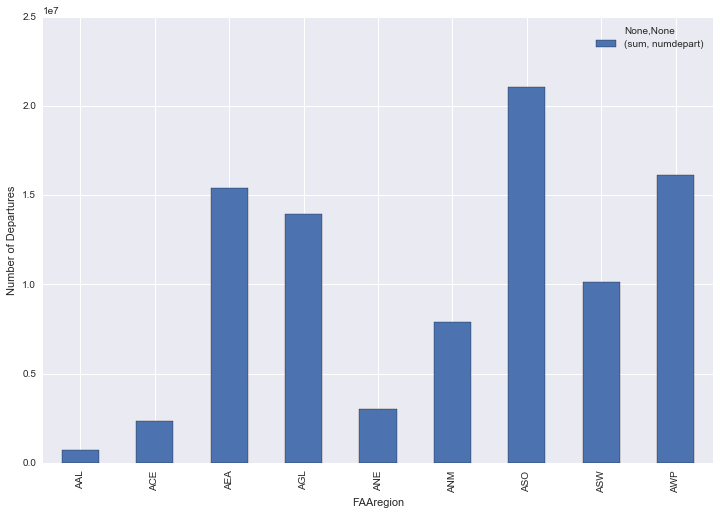

In [44]:
airportpivot2.plot(kind='bar',figsize = (12,8))
plt.ylabel('Number of Departures')

The above graph simply shows FAA region by size (number of departures). It's important to note that the largest region, ANM, had the consistently highest OT% over the 10 year span.

## K-Means Clustering

In [171]:
#setting X and Y variables, scaling data using standard scaler, fitting the kmeans model with k = 5
x = df.ix[:,2:19]
y = df.ix[:,0]
X = x.as_matrix(columns=None)
X = StandardScaler().fit_transform(X)
k = 3
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [172]:
#silhouette score for kmeans model
metrics.silhouette_score(X, labels, metric='euclidean')

0.21972430693095235

## Hierarchical Clustering

In [173]:
Z = linkage(X, 'complete')
c, coph_dists = cophenet(Z, pdist(X))
c

0.7838173401020293

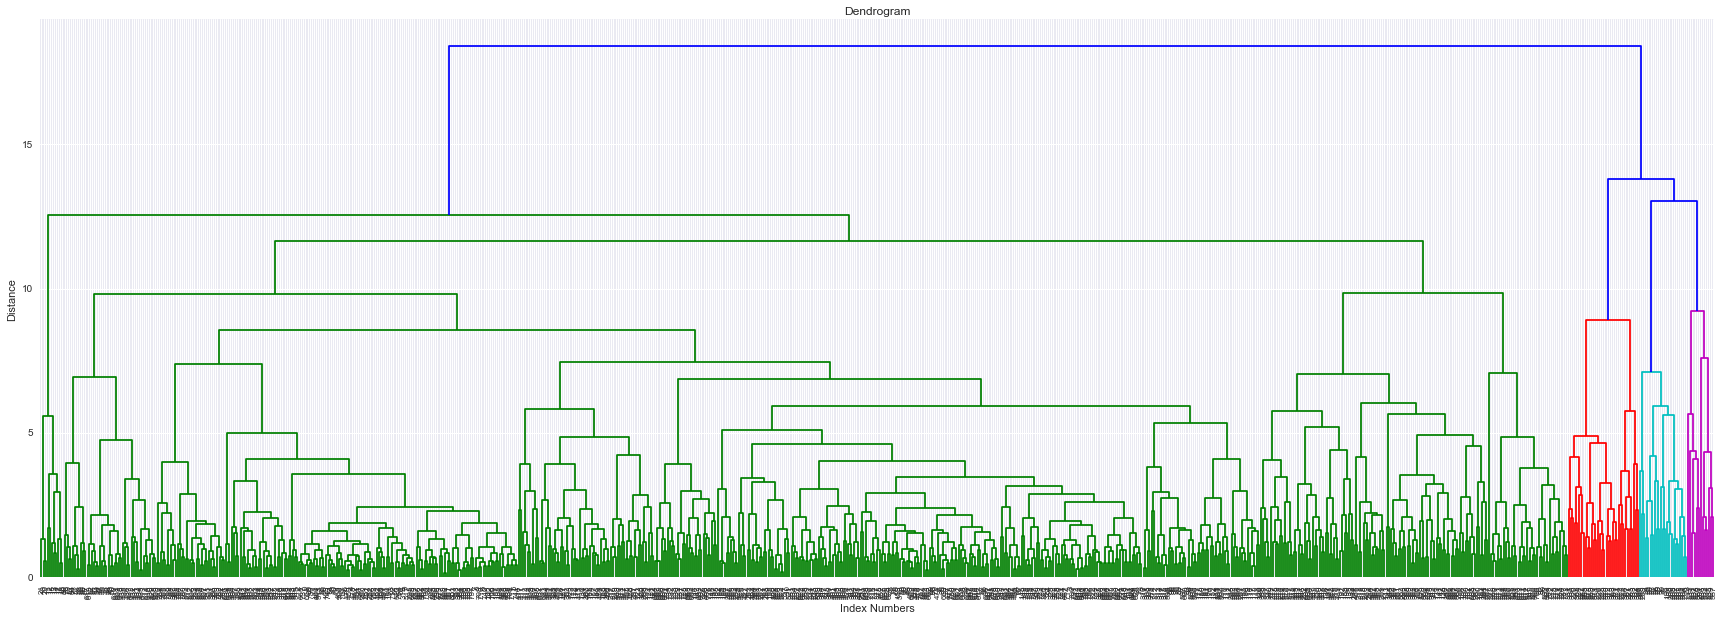

In [174]:
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

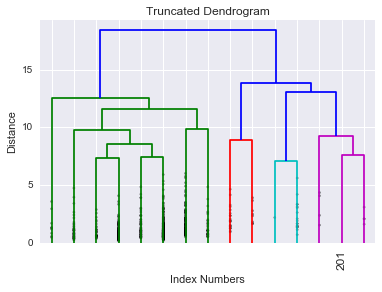

In [175]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [176]:
max_d = 20
clusters = fcluster(Z, max_d, criterion='distance')

In [189]:
metrics.silhouette_score(X, clusters, metric='euclidean')

0.32453590436274765

In [ ]:
plt.scatter(X[:,4], X[:,2], c=clusters, cmap='prism')
plt.show()

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: PCA turns the feature values into simpler components. While this makes for running a less complex model, you no longer have your features to analyze.

### Part 5: PCA

#### 5.1 Conduct the PCA

In [ ]:
covMat1 = np.cov(X.T)
eigenValues, eigenVectors = np.linalg.eig(covMat1)

In [ ]:
eigenValues

In [ ]:
eigenVectors

In [ ]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

In [ ]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
varExpl

In [ ]:
cvarex = np.cumsum(varExpl)
cvarex

In [ ]:
airports_pca = PCA(n_components=3)
airports_pca.fit(X)
pcaX = airports_pca.transform(X)

In [ ]:
dfpca = pd.DataFrame(pcaX,columns=['pca1','pca2','pca3'])
dfpca.head()

In [ ]:
d3 = plt.figure(figsize=(12,8)).gca(projection='3d')
d3.scatter(dfpca.pca1, dfpca.pca2, dfpca.pca3)
d3.set_xlabel('pca1')
d3.set_ylabel('pca2')
d3.set_zlabel('pca3')
plt.show()

ValueError: x and y must have same first dimension

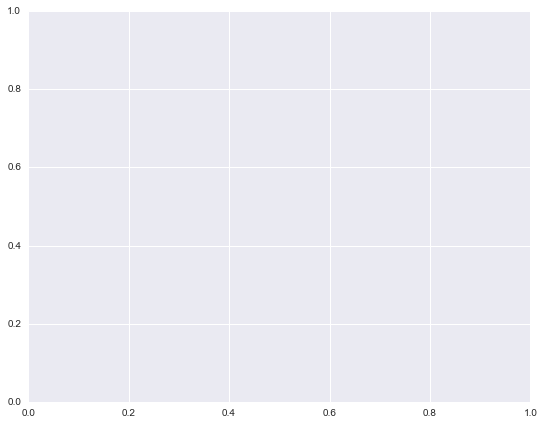

In [178]:
plt.figure(figsize=(9,7))

component_number = [1,2,3]

plt.plot(component_number, cvarex, lw=7)

plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')


ax = plt.gca()
ax.set_xlim([1,3])
ax.set_ylim([-5,105])

ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

In [200]:
k = 3
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(pcaX)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
metrics.silhouette_score(pcaX, labels, metric='euclidean')

0.30841528907336707

In [201]:
Z = linkage(pcaX, 'complete')
c, coph_dists = cophenet(Z, pdist(pcaX))
c

0.66974594887947136

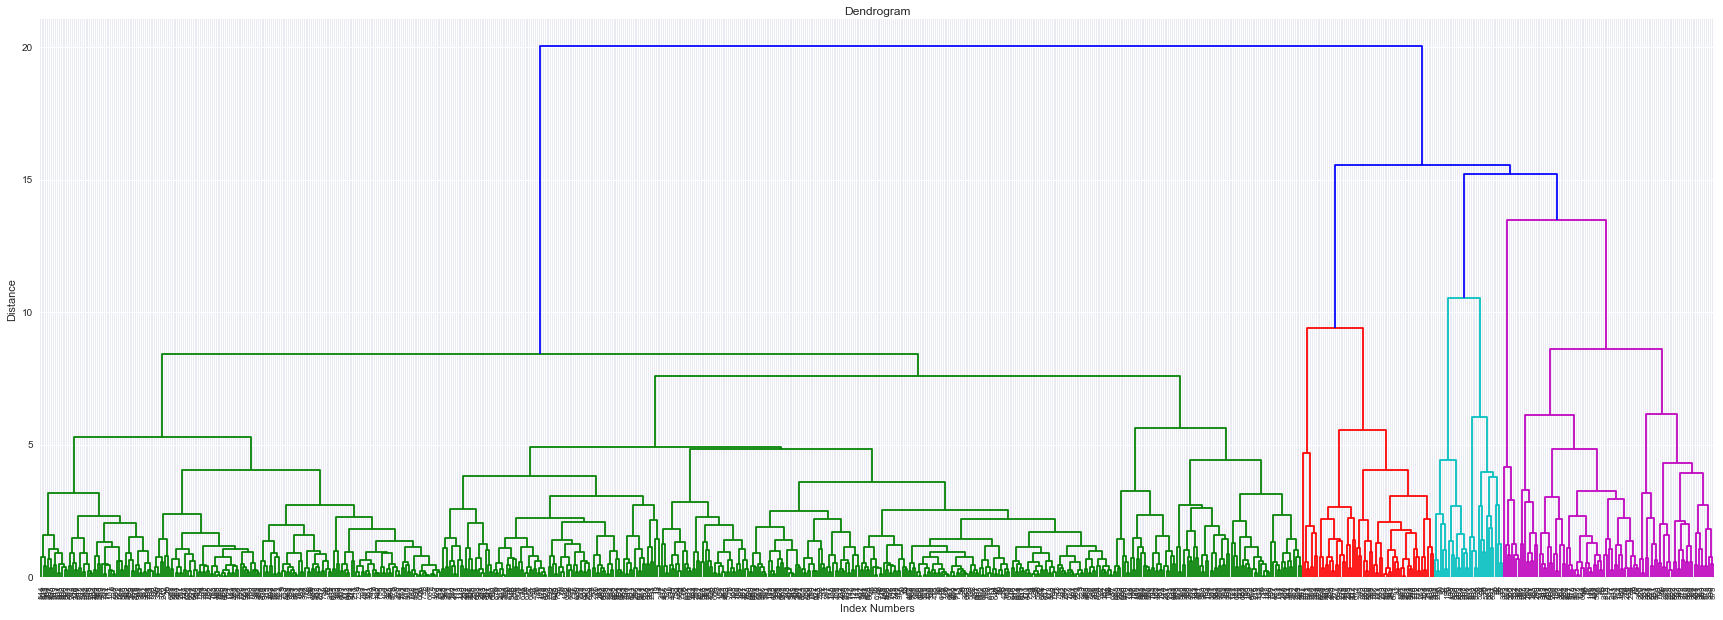

In [202]:
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

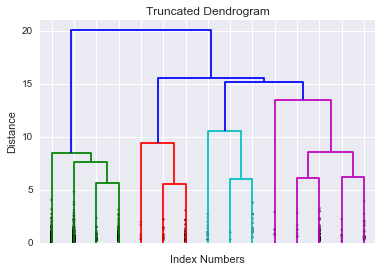

In [203]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [204]:
max_d = 20
clusters = fcluster(Z, max_d, criterion='distance')
metrics.silhouette_score(pcaX, clusters, metric='euclidean')

0.44673473106719214

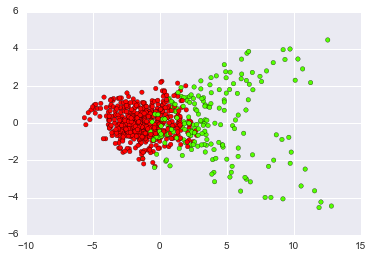

In [205]:
plt.scatter(pcaX[:,0], pcaX[:,2], c=clusters, cmap='prism')
plt.show()

In [206]:
pcaX

array([[-2.66019375,  0.39102302, -0.03078173],
       [-3.04368756,  0.76377836, -0.0264856 ],
       [-2.42829995,  0.11874182, -0.37696355],
       ..., 
       [-3.76685255,  1.19945462,  0.37682922],
       [-2.83945738, -0.13330058, -0.12068505],
       [-2.19282612, -1.02476695, -0.49129115]])

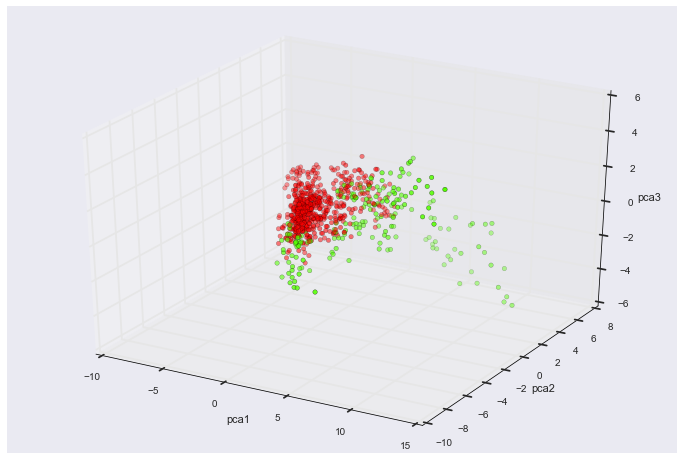

In [207]:
d3 = plt.figure(figsize=(12,8)).gca(projection='3d')
d3.scatter(pcaX[:,0], pcaX[:,1], pcaX[:,2], c=clusters, cmap='prism')
d3.set_xlabel('pca1')
d3.set_ylabel('pca2')
d3.set_zlabel('pca3')
plt.show()

In [208]:
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1,

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

In [151]:
df['delaybinary']=df.avggatearrivdelay.apply(lambda x: 1 if x > np.median(df.avggatearrivdelay) else 0)
df.head()

AttributeError: 'DataFrame' object has no attribute 'avggatearrivdelay'

In [82]:
del df['airport']
del df['pctontimegatedepart']
del df['pctontimearptdepart']
del df['pctontimegatearriv']


In [83]:
del df['avggatearrivdelay']

In [84]:
Xlogreg = df.ix[:,:-1]
#ylogreg = df.ix[:,-1]
lr = model = LogisticRegression()

In [85]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1,

In [86]:
selector = SelectKBest(f_classif, k=5)
selected_data = selector.fit_transform(Xlogreg, labels)
kbest_columns = Xlogreg.columns[selector.get_support()]
Xbest = pd.DataFrame(selected_data, columns=kbest_columns)

X_train, X_test, y_train, y_test = train_test_split(Xbest, labels, stratify=y, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.87241379310344824

In [190]:
coefs = model.coef_
coeflist=[]
for i in coefs[0]:
    coeflist.append(i)
coefdf = pd.DataFrame(coeflist, index = Xbest.columns)
coefdf = coefdf.sort_values(0, ascending = False)
coefdf = coefdf[coefdf.index != 'constant']
coefdf.columns = ['Coef']
coefdf

,Coef
avgtaxiouttime,0.217785
numarriv,0.000031
numdepart,-0.000047
departdiversions,-0.002224
avgtaxiindelay,-0.360957


In [88]:
from sklearn.metrics import classification_report

classification_report(y_test, y_pred)

'             precision    recall  f1-score   support\n\n          0       0.77      0.59      0.67        63\n          1       0.89      0.95      0.92       227\n\navg / total       0.87      0.87      0.87       290\n'

In [89]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 37,  26],
       [ 11, 216]])

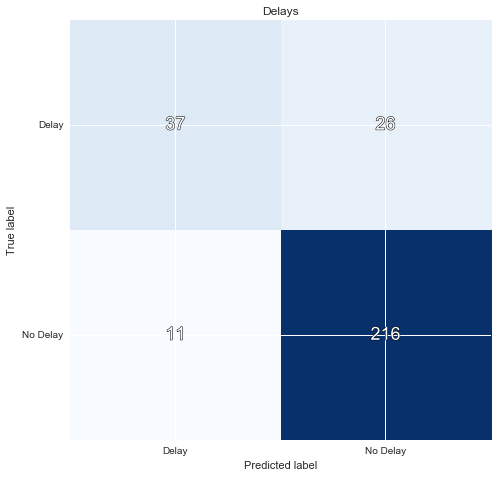

In [95]:
import matplotlib.patheffects as path_effects
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Delays', labels=['Delay','No Delay'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()])

cm = confusion_matrix(y_test, y_pred)
#dfcm = pd.DataFrame(cm, columns=['Predicted Survived','Predicted Deceased'], index=['Actually Survived','Actually Deceased'])
plot_confusion_matrix(cm)

In [97]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
ypreds = rf.predict(X_test)

In [98]:
cm = confusion_matrix(y_test, ypreds)
cm

array([[ 54,   9],
       [  6, 221]])

In [99]:
accuracy_score(y_test, ypreds)

0.94827586206896552

In [100]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = Xbest.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
avgtaxiindelay,0.255689
numarriv,0.248090
numdepart,0.235367
avgtaxiouttime,0.171316
departdiversions,0.089538


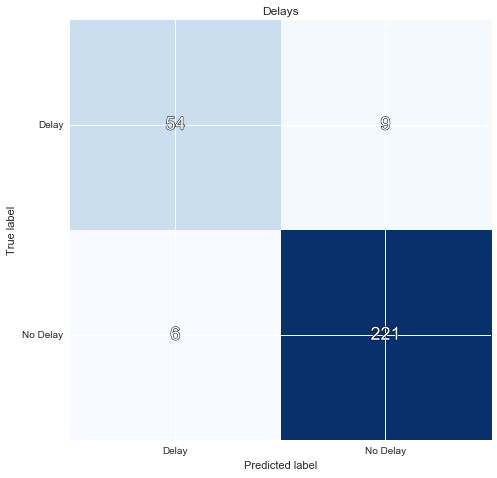

In [101]:
cm = confusion_matrix(y_test, ypreds)
#dfcm = pd.DataFrame(cm, columns=['Predicted Survived','Predicted Deceased'], index=['Actually Survived','Actually Deceased'])
plot_confusion_matrix(cm)

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

http://tptirrell.github.io/AirportDelays/

Which operational features are most correlated with delays?

After running the logistic regression above, the features most correlated with delays are: Avg taxi out time, and size of airport.

What should the airport's next steps be?

First, take a closer look at the AAL region to determine what additional conditions were present that caused the dramatic increase in on-time percentage.
Secondly, ANM, for being the region with the most departures, had the highest consistent OT%. What conditions were present here to maintain that rate?
Finally, taxi delays seem to be the largest contributors to overall delays without respect to airport size. A deeper investigation should be condiucted into root causes and what can be done to minimize delay here.